IMDB sentiment analysis dataset.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

[1] Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011, June). Learning Word Vectors for Sentiment Analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies (pp. 142-150). [Link](http://www.aclweb.org/anthology/P11-1015)

# Scikit-learn

In [1]:
import pandas as pd

data_file = 'data/IMDB Dataset.csv'
df_raw = pd.read_csv(data_file)
df_raw

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


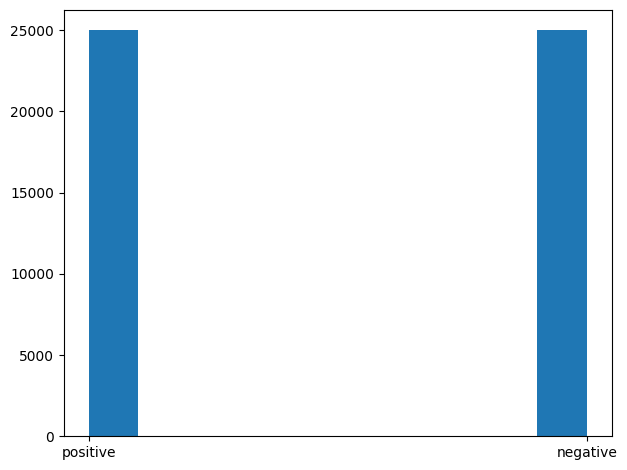

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(df_raw.sentiment)
fig.tight_layout()

In [3]:
df_formatted = pd.DataFrame()
df_formatted['x'] = df_raw.review
df_formatted['y'] = (df_raw.sentiment == 'positive').astype(int)
df_formatted

,x,y
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_formatted, test_size=0.5, random_state=123, stratify=df_formatted.y)
print(f'Train: {df_train.shape}')
print(f'Test: {df_test.shape}')

Train: (25000, 2)
Test: (25000, 2)


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

cv_params = {
    'ngram_range': (1, 3),
    'token_pattern': r'\w+',
}

cv = CountVectorizer(**cv_params)
dtm = cv.fit_transform(df_train.x)
dtm

<25000x5071055 sparse matrix of type '<class 'numpy.int64'>'
	with 15042165 stored elements in Compressed Sparse Row format>

In [6]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(dtm, df_train.y)
print(f'Classes: {nb.classes_}')
print(f'Log probs shape: {nb.feature_log_prob_.shape}')
print(f'Log probs: {nb.feature_log_prob_}')

Classes: [0 1]
Log probs shape: (2, 5071055)
Log probs: [[-11.16970657 -15.35429801 -15.75976312 ... -16.4529103  -16.4529103
  -16.4529103 ]
 [-12.68234324 -15.7733857  -16.46653288 ... -15.7733857  -15.7733857
  -15.7733857 ]]


In [7]:
log_probs = nb.feature_log_prob_[0] - nb.feature_log_prob_[1]
log_probs.shape

(5071055,)

In [8]:
from itertools import islice

vocab = cv.vocabulary_
print(f'Vocab lenght: {len(vocab)}')
print(f'Vocab slice: {dict(islice(vocab.items(), 5))}')

Vocab lenght: 5071055
Vocab slice: {'this': 4414576, 'picture': 3277461, 'hit': 2031312, 'the': 4175157, 'movie': 2791444}


In [9]:
binary_cv = CountVectorizer(binary=True, vocabulary=vocab, **cv_params)
binary_dtm_train = binary_cv.fit_transform(df_train.x)
binary_dtm_test = binary_cv.transform(df_test.x)
probs_train = binary_dtm_train.multiply(log_probs)
probs_test = binary_dtm_test.multiply(log_probs)
print(f'Train probs shape: {probs_train.shape}')
print(f'Test probs shape: {probs_test.shape}')

Train probs shape: (25000, 5071055)
Test probs shape: (25000, 5071055)


In [10]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_probs_train = scaler.fit_transform(probs_train)
scaled_probs_test = scaler.transform(probs_test)

In [11]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10000)
svm.fit(scaled_probs_train, df_train.y)
svm_score = svm.score(scaled_probs_test, df_test.y)
print(f'SVM score: {svm_score}')

SVM score: 0.90404


In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='saga', max_iter=10000)
lr.fit(scaled_probs_train, df_train.y)
lr_score = lr.score(scaled_probs_test, df_test.y)
print(f'LR score: {lr_score}')

LR score: 0.90556


# Ktrain

In [13]:
from ktrain import text as kt

kt.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [14]:
df_raw

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [17]:
trn, val, preproc = kt.texts_from_df(df_raw, 'review', ['sentiment'], ngram_range=3, val_pct=0.5, random_state=123)

['negative', 'positive']
       negative  positive
12942       0.0       1.0
5673        0.0       1.0
28198       1.0       0.0
27926       1.0       0.0
15431       0.0       1.0
['negative', 'positive']
       negative  positive
11872       1.0       0.0
40828       0.0       1.0
36400       0.0       1.0
5166        1.0       0.0
30273       1.0       0.0
language: en
Word Counts: 91146
Nrows: 25000
25000 train sequences
train sequence lengths:
	mean : 229
	95percentile : 582
	99percentile : 892
Adding 3-gram features
max_features changed to 4646862 with addition of ngrams
Average train sequence length with ngrams: 683
train (w/ngrams) sequence lengths:
	mean : 683
	95percentile : 1743
	99percentile : 2673
x_train shape: (25000,400)
y_train shape: (25000, 2)
Is Multi-Label? False
25000 test sequences
test sequence lengths:
	mean : 227
	95percentile : 577
	99percentile : 881
Average test sequence length with ngrams: 530
test (w/ngrams) sequence lengths:
	mean : 530
	95percentile : 1

In [26]:
from pprint import pprint

print('Types:')
pprint({
    'type(trn)': type(trn),
    'type(val)': type(val),
    'type(preproc)': type(preproc),
})

print('Lengths:')
pprint({
    'len(trn)': len(trn),
    'len(val)': len(val),
})

print('SybTypes: ')
pprint({
    'type(trn[0])': type(trn[0]),
    'type(trn[1])': type(trn[1]),
    'type(val[0])': type(val[0]),
    'type(val[1])': type(val[1]),
})

print('Contents: ')
pprint({
    'trn[0]': trn[0],
    'trn[1]': trn[1],
    'val[0]': val[0],
    'val[1]': val[1],
})

Types:
{'type(preproc)': <class 'ktrain.text.preprocessor.StandardTextPreprocessor'>,
 'type(trn)': <class 'tuple'>,
 'type(val)': <class 'tuple'>}
Lengths:
{'len(trn)': 2, 'len(val)': 2}
SybTypes: 
{'type(trn[0])': <class 'numpy.ndarray'>,
 'type(trn[1])': <class 'numpy.ndarray'>,
 'type(val[0])': <class 'numpy.ndarray'>,
 'type(val[1])': <class 'numpy.ndarray'>}
Contents: 
{'trn[0]': array([[      0,       0,       0, ..., 3666715, 1186664, 2103625],
       [      0,       0,       0, ..., 3691366, 3508602,  299609],
       [2768008, 3595178, 4160487, ..., 2167123,  768848,  933285],
       ...,
       [      0,       0,       0, ...,   35861, 2343685, 2369725],
       [      0,       0,       0, ..., 1379769,  299961, 1770039],
       [2252757, 2843810,  994269, ..., 3644354, 3082648, 3091250]]),
 'trn[1]': array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32),
 'val[0]': array([[      0,       0,       0, .

In [27]:
nbsvm_model = kt.text_classifier('nbsvm', trn, preproc)
type(nbsvm_model)

Is Multi-Label? False
compiling word ID features...
maxlen is 400
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-25000
computing log-count ratios...
done.


keras.engine.functional.Functional

In [33]:
import ktrain

nbsvm_learner = ktrain.get_learner(nbsvm_model, trn, val)
type(nbsvm_learner)

ktrain.core.ArrayLearner

simulating training for different learning rates... this may take a few moments...
Epoch 1/100
782/782 [==============================] - 30s 37ms/step - loss: 0.6928 - accuracy: 0.5168
Epoch 2/100
782/782 [==============================] - 29s 37ms/step - loss: 0.6919 - accuracy: 0.5528
Epoch 3/100
782/782 [==============================] - 29s 37ms/step - loss: 0.6908 - accuracy: 0.5989
Epoch 4/100
782/782 [==============================] - 29s 37ms/step - loss: 0.6894 - accuracy: 0.6508
Epoch 5/100
782/782 [==============================] - 29s 38ms/step - loss: 0.6878 - accuracy: 0.7063
Epoch 6/100
782/782 [==============================] - 30s 38ms/step - loss: 0.6858 - accuracy: 0.7652
Epoch 7/100
782/782 [==============================] - 30s 38ms/step - loss: 0.6834 - accuracy: 0.8213
Epoch 8/100
782/782 [==============================] - 31s 40ms/step - loss: 0.6805 - accuracy: 0.8700
Epoch 9/100
782/782 [==============================] - 31s 40ms/step - loss: 0.6771 - accurac

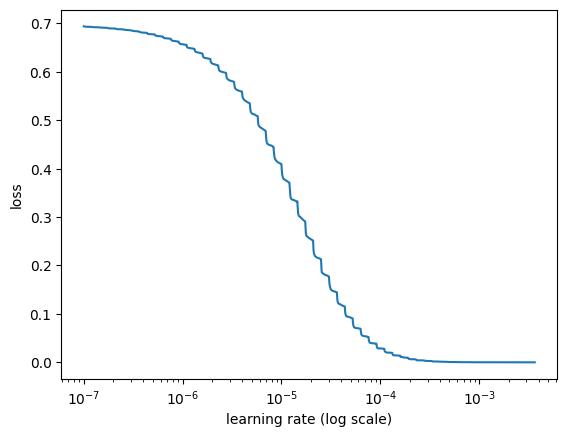

In [31]:
nbsvm_learner.lr_find(show_plot=True, max_epochs=100)

In [35]:
nbsvm_learner.autofit(10e-5, early_stopping=3)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1024
782/782 [==============================] - 31s 40ms/step - loss: 0.3406 - accuracy: 0.9870 - val_loss: 0.4020 - val_accuracy: 0.9084
Epoch 2/1024
782/782 [==============================] - 28s 36ms/step - loss: 0.2329 - accuracy: 0.9919 - val_loss: 0.3546 - val_accuracy: 0.9101
Epoch 3/1024
782/782 [==============================] - 31s 40ms/step - loss: 0.1677 - accuracy: 0.9942 - val_loss: 0.3230 - val_accuracy: 0.9121
Epoch 4/1024
782/782 [==============================] - 29s 38ms/step - loss: 0.1250 - accuracy: 0.9956 - val_loss: 0.3006 - val_accuracy: 0.9136
Epoch 5/1024
782/782 [==============================] - 29s 37ms/step - loss: 0.0951 - accuracy: 0.9969 - val_loss: 0.2833 - val_accuracy: 0.9145
Epoch 6/1024
782/782 [==============================] - 36s 46ms/step - loss: 0.0737 - accuracy: 0.9976 - val_loss: 0.2700 - val_accurac

In [36]:
nbsvm_learner.evaluate(print_report=True)

782/782 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     12574
           1       0.91      0.94      0.92     12426

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000



array([[11357,  1217],
       [  806, 11620]], dtype=int64)